# Устанока либ

In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

# Подключение нужных библиотек

In [2]:
import os
import pickle # для сохранения класса

import pandas as pd 
import numpy as np

import sklearn

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Заранее установим несколько констант
RANDOM_STATE = 42

# Подготока данных

In [4]:
def load_data():
    # загрузка данных
    data = pd.read_csv("data/Clean_Dataset.csv")
    # убираем не нужный столбик с индексами
    data = data.drop(data.columns[0], axis=1)
    return data

data = load_data()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


Описание признаков нашего набора данных.

1) Авиакомпания (Airline): Название авиакомпании. Категориальный признак, содержащий 6 уникальных авиакомпаний.
2) Рейс (Flight): Код рейса самолета. Категориальный признак.
3) Город вылета (Source City):Город, из которого вылетает рейс. Категориальный признак с 6 уникальными городами.
4) Время вылета (Departure Time):Производный категориальный признак, созданный путем группировки временных интервалов в бины. Содержит информацию о времени вылета и имеет 6 уникальных меток времени.
5) Остановки (Stops):Категориальный признак с 3 уникальными значениями, указывающий количество остановок между городами вылета и назначения.
6) Время прибытия (Arrival Time):Производный категориальный признак, созданный группировкой временных интервалов в бины. Содержит 6 уникальных меток времени прибытия.
7) Город назначения (Destination City):Город, в который прилетает рейс. Категориальный признак с 6 уникальными городами.
8) Класс (Class):Категориальный признак, указывающий класс места. Имеет два значения: Бизнес (Business) и Эконом (Economy).
9) Длительность (Duration):Непрерывный признак, отображающий общее время путешествия между городами в часах.
10) Дней до вылета (Days Left):Производный признак, вычисляемый как разница между датой вылета и датой бронирования.
11) Цена (Price):Целевая переменная, содержащая информацию о стоимости билета.

Рассмотрим уникальные значения для категориальных признаков

In [6]:
def get_info_unique(select_dtype_include = 'object'):
    for column in data.select_dtypes(include=select_dtype_include).columns:
        column_unique = data[column].unique()
        print("==="*30)
        print(f"| {column:15} (count:{len(column_unique):3})")
        print(f"| {column_unique}")
    print("==="*30)

get_info_unique()

| airline         (count:  6)
| ['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']
| flight          (count:1561)
| ['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
| source_city     (count:  6)
| ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
| departure_time  (count:  6)
| ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
| stops           (count:  3)
| ['zero' 'one' 'two_or_more']
| arrival_time    (count:  6)
| ['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']
| destination_city (count:  6)
| ['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']
| class           (count:  2)
| ['Economy' 'Business']


Реализуем пользовательский класс для предобработки данных без использования наследования. Его цель - преобразовать все категориальные признаки в числовые, чтобы линейные модели могли корректно работать с данными и предсказывать целевой признак.

Теперь рассмотрим, что будет представлять из себя созданный нами класс.
В классе идёт обработка по следующим шагам.

1) Первичная обработка.
    - Кодировка stops в формате ```{"zero":0, "one":1, "two_or_more":2}```
    - Разделение фичи flight на ```flight_value``` и ```flight_tag``` это нужно будет для дальнейших преобразований;
2) Теперь перейдём к трансформациям. Будем брать классы из sklearn.preprocessing.
    - ```OrdinalEncoder()``` - класс с помощью которого, мы кодируем фичи с ```object``` типом в цифровой. В нашем случае это фича ``` class```, которая имеет 2 уникальных значения *"Economy"* и *"Business"* и приводим мы их к значениям 1 и 0 соответственно. (```OrdinalEncoder()``` начинает отсчёт для кодировки по алфавиту "E" < "B");
    - ```OneHotEncoder()``` - класс создающий бинарные признаки для каждого уникального значения. Пример: Признак ```airline``` преобразуется в столбцы ```airline_Indigo, airline_SpiceJet, airline_Vistara...```
    - ```MinMaxScaler()``` - класс который нормализирует числовые значения на диапазоне [0,1];
3) Сохраняем обученные трансформеры с помощью метода ```.save()``` сохраняется по умолчанию по пути _data/preprocessing/_. А так же если вам не нужно обучать модель она сама загрузит сохранённые трансформеры из заданной директории. (Её можно изменить с помощью парметра ```path_dir_w``` при создании класса);
4) Изменённые данные можно получить с помощью метода ```get_data()```. Так же методы ```fit_transform()``` и ```transform()``` возвращают изменённые данные.

Краткое обоснование выбора методов:
- ```OrdinalEncoder``` выбран для бинарных признаков (class) с естественным порядком.
- ```OneHotEncoder``` применен к признакам, где нет иерархии между категориями.
- ```MinMaxScaler``` обеспечивает одинаковый масштаб для числовых признаков, что критично для линейных моделей.


In [7]:
class PreprocessingDataInNumber():

    def __init__(self, df: pd.DataFrame, path_dir_w=None):
        self._df = df.copy()

        self.path_dir_w = path_dir_w
        # если есть папка с обученными весами
        if not self.path_dir_w:
            self.path_dir_w = "data/preprocessing"
        if not os.path.exists(self.path_dir_w):
                os.makedirs(self.path_dir_w)
        
        self._transforms_for_sklearn = [
            ("class_enc", sklearn.preprocessing.OrdinalEncoder(), ["class"]),
            ("route_enc", sklearn.preprocessing.OneHotEncoder(sparse_output=False), ["route", "time_to_time", "airline", "flight_tag"]),
            ("number_columns_MinMaxScaler", sklearn.preprocessing.MinMaxScaler(), ["duration","flight_value","days_left"])
        ]
        self._simple_transform = [
            ("stops_enc", self.stops_encoding, ["stops"]),
            ("flight_enc", self.flight_encoder, ["flight"]),
        ]

        self.load_w()
    
    def load_w(self):
        for filename in os.listdir(self.path_dir_w):
            file_path = os.path.join(self.path_dir_w, filename)
            with open(file_path, 'rb') as f:
                for index, (name, func, columns) in enumerate(self._transforms_for_sklearn):
                    if name == filename[:-4]:
                        load_encoder = pickle.load(f)
                        self._transforms_for_sklearn[index] = (name, load_encoder, columns)

    def save(self):
        current_directory = os.getcwd()
        path = os.path.join(current_directory, self.path_dir_w)        
        for name, func, _ in self._transforms_for_sklearn:
            with open(f"data/preprocessing/{name}.pkl", "wb") as f: 
                pickle.dump(func, f)

                

    def _fit(self):
        self.create_new_columns()
        
        for _, func, _ in self._simple_transform:
            func()

        for name, func, columns in self._transforms_for_sklearn:
            func.fit(self._df[columns])

    def transform(self):
        if "route" in self._df.columns:
            pass
        else:    
            self.create_new_columns()

        if "flight_tag" not in self._df.columns:
            for _, func, _ in self._simple_transform:
                func()

        for name, func, columns in self._transforms_for_sklearn:
            
            if isinstance(func, sklearn.preprocessing.OneHotEncoder):
                transform_array = func.transform(self._df[columns])
                for ind, new_column in enumerate(func.get_feature_names_out()):
                    self._df[new_column] = transform_array[:,ind]
                self._df = self._df.drop(columns, axis=1)
                continue

            if isinstance(func, sklearn.preprocessing.OrdinalEncoder):
                func.transform(self._df[columns])
                self._df["is_economy_class"] = func.transform(self._df[columns])
                self._df = self._df.drop(columns, axis=1)
                continue

            if isinstance(func, sklearn.preprocessing.MinMaxScaler):
                transform_array = func.transform(self._df[columns])
                self._df[columns] = transform_array
                continue
        return self.get_data()
            
    def create_new_columns(self):
        self._df["route"] = self._df['source_city'] + "-" + self._df['destination_city']
        self._df = self._df.drop(['source_city', 'destination_city'], axis=1)

        self._df["time_to_time"] = self._df['departure_time'] + "-" + self._df['arrival_time']
        self._df = self._df.drop(['departure_time', 'arrival_time'], axis=1)

    def get_data(self):
        return self._df.copy()
    
    def fit_transform(self):
        self._fit()
        self.transform()
        return self.get_data()
        
    def stops_encoding(self):
        stops_dict = {
            "zero": 0,
            "one":  1,
            "two_or_more": 2,
        }
        self._df["stops"] = self._df["stops"].apply(lambda x: stops_dict[x])

    def flight_encoder(self):
        self._df["flight_tag"] = self._df["flight"].apply(lambda x: x[:2])
        self._df["flight_value"] = self._df["flight"].apply(lambda x: x[3:]).astype(dtype='int64')
        self._df = self._df.drop("flight", axis=1)

In [8]:
data = load_data()
prepoc = PreprocessingDataInNumber(data)


#  Вариант если впервые проходите по блокноту
prepoc.fit_transform()
prepoc.save()
data_df = prepoc.get_data()

#  Вариант проходите по блокноту повторно
# data_df = prepoc.transform()

In [9]:
data_df

,stops,duration,days_left,price,flight_value,is_economy_class,route_Bangalore-Chennai,route_Bangalore-Delhi,route_Bangalore-Hyderabad,route_Bangalore-Kolkata,...,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_tag_6E,flight_tag_AI,flight_tag_G8,flight_tag_I5,flight_tag_SG,flight_tag_UK
0,0,0.027347,0.0,5953,0.870374,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0.030612,0.0,5953,0.814560,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.027347,0.0,5956,0.067037,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,0.028980,0.0,5955,0.090394,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.030612,0.0,5955,0.087159,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,1,0.188776,1.0,69265,0.072902,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
300149,1,0.195714,1.0,77105,0.073306,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
300150,1,0.265306,1.0,79099,0.073913,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
300151,1,0.187143,1.0,81585,0.073509,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Разделение на тестовую и обучающую выборки
Для базового разделения данных используем метод `train_test_split` из библиотеки scikit-learn. 
Данные будут разделены на обучающую и тестовую выборки в соотношении **80:20**.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_df.drop("price", axis=1), data_df["price"],
                                                    test_size=0.2, random_state=RANDOM_STATE) 

# Подготовка к разбору моделей 

## Метрики

Метрики - ключевой элемент машинного обучения, так как они позволяют оценить, насколько эффективна модель, и определить направление её улучшения

Для оценки качества регрессионной модели, предсказывающей цены, необходимо выбрать метрики, учитывающие специфику задачи. В отличие от классификации, регрессия требует измерения величины ошибки и объясненной дисперсии.

|Метрика|Плюсы|Минусы|Cсылка на функцию|
|-|-|-|-|
|MAE|Устойчивость к выбросам, интерпретируемость|Игнорирует крупные ошибки|[mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)|
|MSE|Акцент на крупные ошибки, дифференцируемость|Чувствительность к выбросам|[mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)|
|R^2|Сравнение моделей, безразмерность|Не показывает абсолютные ошибки|[r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)|
|MAPE|Процентная интерпретация|Проблемы с нулями и асимметрия|[mean_absolute_percentage_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error)|
|MSLE|Учет относительных ошибок|Сложная интерпретация|[mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error)|

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error

def full_metrics(y_true, y_pred, is_show_terminal=True):
    """
        Получение разнообразных оценок регрессионной модели
        
        Параметры:
        is_show_terminal - print(полученные результаты)

        Return:
        dict в виде {название_метрики: значение}
    """

    metrics = {
        "MAE" : mean_absolute_error, 
        "MSE" : mean_squared_error, 
        "RMSE" : lambda y_t, y_p: np.sqrt(mean_squared_error(y_t, y_p)),
        "R^2" : r2_score, 
        "MAPE" : mean_absolute_percentage_error, 
        "MSLE" : mean_squared_log_error,
        "RMSLE": lambda y_t, y_p: np.sqrt(mean_squared_log_error(y_t, y_p))} 

    result_metric = {}

    for name, metric in metrics.items():
        try:
            result_metric[name] = round(metric(y_true, y_pred),2)
        except:
            result_metric[name] = "Ошибка!!!"
    
    if is_show_terminal:
        for name, value in result_metric.items():
            print(f"{name:5}:{value}")

    return result_metric

## Журнал истории(пользовательский класс для хранения моделей и их метрик)

Поскольку мы планируем тестировать различные модели, предлагаю создать класс для хранения обученных моделей, их параметров, дополнительной информации метрик. Получать данные мы сможем двумя способами:
- Метод ```to_dataframe``` - получаем информацию о всех наших моделях в формате ```pd.DataFrame```;
- Индексирование ```history[index]```, где ```history``` - объект нашего класса. На выходе мы получим обученную модель под заданным индексом. Принцип работы аналогичен методу ```DataFrame.iloc[index]```.

|Модель|Класс модели|Параметры модели|MAE|MSE|RMSE|R^2|MAPE|MSLE|RMSLE|Заметки|
|-|-|-|-|-|-|-|-|-|-|-|
|LinearRegression|linear_model|-|123|23|43|5|654|4|234|После предсказания все отрицательные значения стали 0-мя|
|SGDRegressor|linear_model|-|123|23|43|5|654|4|234|-|

Таким образом, мы сможем удобно анализировать результаты работы разных моделей, а также сравнивать их параметры. Это позволит выбрать модель с оптимальными метриками.

In [12]:
class ModelsHistory():
    
    def __init__(self):
        self.models = []
        self.class_models = []
        self.params_models = []
        self.metrics_models = []
        self.notes_models = []
        

    def add_model(self, model, class_model, params, note, metrics = None, y_true = None, y_pred = None):
        self.models.append(model)
        self.class_models.append(class_model)
        self.params_models.append(params)
        self.notes_models.append(note)

        if not metrics:
            metrics_dict = self._full_metrics(y_true, y_pred)
            values = []
            for value in metrics_dict.values():
                values.append(value)
            self.metrics_models.append(values)
        else:
            self.metrics_models.append(metrics)
        
    def to_dataframe(self):
        metrics_name = ["MAE", "MSE", "RMSE", "R^2", "MAPE", "MSLE" ,"RMSLE"]

        return pd.DataFrame(
            
            {
                "Модели": [type(model).__name__ for model in self.models],
                "Класс модели": self.class_models,
                "Параметры модели": self.params_models,
                **dict(zip(metrics_name, zip(*self.metrics_models))),
                # "Метрики": self.metrics_models,
                "Заметки": self.notes_models
            }
        )

    def _full_metrics(self, y_true, y_pred, is_show_terminal=None):
        """
            Получение разнообразных оценок регрессионной модели
            
            Параметры:
            is_show_terminal - print(полученные результаты)

            Return:
            dict в виде {название_метрики: значение}
        """

        metrics = {
            "MAE" : mean_absolute_error, 
            "MSE" : mean_squared_error, 
            "RMSE" : lambda y_t, y_p: np.sqrt(mean_squared_error(y_t, y_p)),
            "R^2" : r2_score, 
            "MAPE" : mean_absolute_percentage_error, 
            "MSLE" : mean_squared_log_error,
            "RMSLE": lambda y_t, y_p: np.sqrt(mean_squared_log_error(y_t, y_p))} 

        result_metric = {}

        for name, metric in metrics.items():
            try:
                result_metric[name] = round(metric(y_true, y_pred),4)
            except:
                result_metric[name] = None
        
        if is_show_terminal:
            for name, value in result_metric.items():
                print(f"{name:5}:{value}")

        return result_metric
    
    def __getitem__(self, index):
        return {
            "Model":self.models[index],
            "Class_model":self.class_models[index],
            "Params":self.params_models[index],
            "Notes":self.notes_models[index],
        }

Давайте заранее создадим экземпляр класса. Для работы с ним

In [13]:
history_models = ModelsHistory()

# Создание моделей

## Линейные модели

In [14]:
from sklearn import linear_model

### ```LinearRegression()```

#### Описание метода

Линейная регрессия - модель, которая строит линейную зависимость между данными и предсказывает по этим зависиимостям целевой признак(*target*) в зависимости от числового значения признаков. Если разбирать линейную модель построенную для случая с двумя признаками, то предсказания будут строиться по формуле:
$$ 
    y = w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 
$$
где:
- $y$ - целевая переменная
- $w_0$ - смещение
- $w_1$, $w_2$ - коэффициенты при признаках $x_1$ и $x_2$


На рисунке ниже представлена геометрическая интерпретация.

![Геометрический смысл линейной регрессии](./data/images/linearRegression/geometric_meaning.png)

Функцией потерь для линейной модели в ```sklearn``` это *SSE*, которая на практике часто используется как синоним MSE т.к. $MSE = \frac{1}{n}SSE$

Формула для рассчитывания потери
$$
Loss(SSE) = \sum^n_{i=2}(y_i-\overline{y}_i)^2
$$
где:
- y - истинное значение целевого переменной
- $\overline{y}$ - предсказанное значение переменной
- n - количество имеющихся обьектов

Теперь перейдём к тому, что отличает LinearRegression от остальных линейных регрессий из библиотеки ```sklearn```

Коэффициенты вычисляются аналитическим решением, которое вычисляет оптимальные коэффициенты за счёт вычисления псевдообратной матрицы. Псевдообратная матрица вычисляется в свою очередь через *SVD*(сингулярное разложение), что позволяет нам решить проблемы в случаях мультиколлинеарности и вырожденности данных.

Формула SVD([подробнее про SVD](http://machinelearning.ru/wiki/index.php?title=SVD)):
$$
X = VDU^T
$$
где: 

- V и U - ортогональные матрицы
- D - диагональная матрица сингулярных значений

Формула псевдообратной матрицы:
$$
X^+=VD^+U^T
$$
где:
- $D^+$ - диагональная матрица, где каждое сингулярное значение $σ_i$ заменяется на 1/$σ_i$, если $σ_i$ > 0, и на 0 иначе
- V и $U^T$ ортогональные матрицы, как и в SVG

После нахождения псевдообратной матрицы коэффициенты линейной регрессии рассчитываются по принципу перемножения псевдообратной матрицы $X^+$ на вектор $y$.
$$
w = X^+y
$$

#### Код и реализация

In [15]:
LR_standart = linear_model.LinearRegression()
LR_standart.fit(X_train, y_train)
y_pred = LR_standart.predict(X_test)

history_models.add_model(LR_standart, "linear_model", LR_standart.get_params(), "Линейная регрессия, с аналитическим оптимизатором", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"


### ```Ridge()```

Класс ```Ridge()``` отличается от класса ```LinearRegression``` наличием L2-регуляризации. Мы можем контролировать силу регуляризации с помощью параметра ```alpha```(стандартное значение 1.0). 

Давайте рассмотрим, что такое L2-регуляризация для понимания сути различия ```Ridge()``` с ```LinearRegression```

Зачем нужна регуляризация?
* Уменьшает переобучение
* Решает проблему колинеарности
* Задача оптимизации становится устойчивее

L2-регуляризация([гребневая регуляризация](https://deepmachinelearning.ru/docs/Machine-learning/Base-concepts/Regularization)) добавляется к оптимизационнной функции модели штрафную функцию вида:
$$ 
alpha*R(w) = alpha*∑^{D}_{d=1}w^2_d 
$$
где:
- alpha - гиперпараметр задаваемый нами
- D - количество признаков
- w - веса модели 

Также отметим, что в классе ```Ridge``` мы можем изменить метод решения. Задав значение для переменной ```solver:{"auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"}, default="auto"```. Рассматривать подробно каждый вариант функции оптимизации мы не будем, так как ```Ridge()``` может автоматически подобрать наиболее походящий алгоритм в зависимости от данных.

In [16]:
LR_Ridge = linear_model.Ridge()
LR_Ridge.fit(X_train, y_train)
y_pred = LR_Ridge.predict(X_test)

history_models.add_model(LR_Ridge, "linear_model", LR_Ridge.get_params(), "Линейная регрессия, с регуляризацией", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,None,None,"Линейная регрессия, с регуляризацией"


### ```RidgeCV()```

Рассмотрим ```RidgeCV()```. В отличие от класса ```Ridge()```, он  наличием кросс-валидации параметра ```alpha```, который отвечает за величину штрафа за большое значение коэффициента.

In [17]:
LR_RidgeCV = linear_model.RidgeCV(alphas=[0.2, 0.6, 1.0, 1.5, 3.8, 10.0, 14.0])
LR_RidgeCV.fit(X_train, y_train)
y_pred = LR_RidgeCV.predict(X_test)


In [18]:
history_models.add_model(LR_RidgeCV, "linear_model", LR_RidgeCV.get_params(), "Линейная регрессия, с регуляризацией и кросс-валидацией", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,None,None,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,None,None,"Линейная регрессия, с регуляризацией и кросс-в..."


### ```SGDRegressor()```

Давайте разберём по пунктам класс `SGDRegressor()`.
- Наша модель изменяется с помощью *SGD(стохастический [градиентный спуск](https://neurohive.io/ru/osnovy-data-science/gradient-descent/))* это один из ключевых методов в машинном обучении, особенно эффективно при работе с большими объёмами данных.
- С помощью параметра `penalty` можем назначить один из способов регуляризации `['l2', 'l1', 'elasticnet']`.
- Параметр `loss` определяеи тип функцию потерь, которую будет минимизировать модель `["squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]`:
    - `"squared_error"` — стандартная среднеквадратичная ошибка (по умолчанию),
    - `"huber"` — более устойчива к выбросам,
    - `"epsilon_insensitive"` и `"squared_epsilon_insensitive"` — используются в задачах поддержки вектора (аналогично `SVR`).

- С помощью параметра ```learning_rate``` можно изменять скорость обучения:
    - `"constant"` — постоянная скорость обучения,
    - `"optima"` — автоматически выбирает оптимальное значение,
    - `"invscaling"` - скорость уменьшается со временем по определённой формуле,
    - `"adaptive"` - скорость уменьшается только при отсутствии улучшения.

- Параметр `"max_iter"` определяет максимальное количество итераций(эпох) обучения. При работе с большим количеством данных важно установить это значение разумно.

- С помощью задания `"early_stopping=True"` можно включить механизм остановки обучения при прекращении улучшения функции потерь.


In [19]:
LR_SGDRegressor = linear_model.SGDRegressor()
LR_SGDRegressor.fit(X_train, y_train)
y_pred = LR_SGDRegressor.predict(X_test)

In [20]:
history_models.add_model(LR_SGDRegressor, "linear_model", LR_SGDRegressor.get_params(), "Линейная регрессия, с SGD", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,None,None,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,None,None,"Линейная регрессия, с регуляризацией и кросс-в..."
3,SGDRegressor,linear_model,"{'alpha': 0.0001, 'average': False, 'early_sto...",4533.9161,4.481212e+07,6694.1856,0.9131,0.4562,None,None,"Линейная регрессия, с SGD"


### `OrthogonalMatchingPursuit()`

Отличие данного класса от остальных заключается в его способности уменьшать количество признаков. Он находит самые влиятельные признаки из имеющихся и на их основе строит модель. (*жадно отбирает признаки*)

Алгоритм отбора признаков:
1) Инициализация:
    - Создаётся пустой список признаков.
    - Остаток r = y (это то, что модель ещё не обьяснила)
2) На каждом шаге:
    - Вычисляется корреляция между каждым признаком и текущим остстатком r
    - Признак с максимальной корреляцией добавляем в список выбранных
    - Строим модель по методу наименьших квадратов(используем только выбранные признаки)
    - обновляем остаток $r = y - X_{выбранные}*w$
3) Повторяем 2 пукт пока не удоврится одно из следующих вариантов:
    - не выбрано заданное количество признаков в гиперпараметре `n_nonzero_coefs`
    - r минимален
    - не закончились признаки 

In [21]:
LR_OrthogonalMatchingPursuit = linear_model.OrthogonalMatchingPursuit(
    # у нас есть больше 70 признков, давайте попробуем задать максисальное количество признаков равное 50
    n_nonzero_coefs=50
)
LR_OrthogonalMatchingPursuit.fit(X_train, y_train)
y_pred = LR_OrthogonalMatchingPursuit.predict(X_test)

In [22]:
history_models.add_model(LR_OrthogonalMatchingPursuit, "linear_model", LR_OrthogonalMatchingPursuit.get_params(), "Линейная регрессия, c использованием OMP", y_true=y_test, y_pred=y_pred)
print('Параметры:', LR_OrthogonalMatchingPursuit.get_params())
history_models.to_dataframe()

Параметры: {'fit_intercept': True, 'n_nonzero_coefs': 50, 'precompute': 'auto', 'tol': None}


,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,None,None,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,None,None,"Линейная регрессия, с регуляризацией и кросс-в..."
3,SGDRegressor,linear_model,"{'alpha': 0.0001, 'average': False, 'early_sto...",4533.9161,4.481212e+07,6694.1856,0.9131,0.4562,None,None,"Линейная регрессия, с SGD"
4,OrthogonalMatchingPursuit,linear_model,"{'fit_intercept': True, 'n_nonzero_coefs': 50,...",4520.2388,4.488049e+07,6699.2903,0.9129,0.4506,None,None,"Линейная регрессия, c использованием OMP"


### `ARDRegression()`

Байевский метод линейной регрессии, который автоматически определяет релевантные признаки. Он использует отдельную регуляризацию для каждого признака, постепенно обнуляя коэфициенты неинформативных признаков.

In [23]:
LR_ARDRegression = linear_model.ARDRegression()
LR_ARDRegression.fit(X_train, y_train)
y_pred = LR_ARDRegression.predict(X_test)

In [24]:
history_models.add_model(LR_ARDRegression, "linear_model", LR_ARDRegression.get_params(), "Линейная регрессия, c байевского метода", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,None,None,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,None,None,"Линейная регрессия, с регуляризацией и кросс-в..."
3,SGDRegressor,linear_model,"{'alpha': 0.0001, 'average': False, 'early_sto...",4533.9161,4.481212e+07,6694.1856,0.9131,0.4562,None,None,"Линейная регрессия, с SGD"
4,OrthogonalMatchingPursuit,linear_model,"{'fit_intercept': True, 'n_nonzero_coefs': 50,...",4520.2388,4.488049e+07,6699.2903,0.9129,0.4506,None,None,"Линейная регрессия, c использованием OMP"
5,ARDRegression,linear_model,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",4521.4472,4.478265e+07,6691.9837,0.9131,0.4526,None,None,"Линейная регрессия, c байевского метода"


### ```PolynomialFeatures()``` + ```LinearRegressor()```

Полиномиальная регрессия - это метод машинного обучения, который используется в моделировании нелинейных зависимостей между переменными. Этот метод позволит нам найти более сложные зависимости между имеющимися атрибутами.

Обозначим преимущества и недостатки этого метода

**Преимущества**
* Гибкость - может найти сложные зависимости
* Подходит для анализа данных с криволинейными трендами (к примеру: валюта начала скакать, то вверх, то вниз в зависимости от месяца года а наши авиакомпания при формировании цены ссылаются на курс валюты)

**Недостатки**
* Возможно переобучение
* Чувствительна к выбросам

In [25]:
# создадим полиномиальные признаки
poly = sklearn.preprocessing.PolynomialFeatures(degree=2) 
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

Выше мы добавили полиномиальные признаки во второй степени.

Пример:
 1) У нас есть признаки *a* и *b*. 
 2) Обрабатываем с помощью класса ```PolynomialFeatures``` 
 3) На выходе мы получаем атрибуты вида *$1, a, b, a^2, b^2, ab$*

Теперь когда мы преобразовали наши признаки к полиномиальному виду мы можем использовать любую из разобранных нами линейных регрессий. Я возьму стандартную линейную регрессию.

In [26]:
PLR_standart = linear_model.LinearRegression()
PLR_standart.fit(X_poly_train, y_train)
y_pred = PLR_standart.predict(X_poly_test)

In [27]:
history_models.add_model(PLR_standart, "poly_linear_model", PLR_standart.get_params(), "Полиномиальная линейная регрессия", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,None,None,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,None,None,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,None,None,"Линейная регрессия, с регуляризацией и кросс-в..."
3,SGDRegressor,linear_model,"{'alpha': 0.0001, 'average': False, 'early_sto...",4533.9161,4.481212e+07,6694.1856,0.9131,0.4562,None,None,"Линейная регрессия, с SGD"
4,OrthogonalMatchingPursuit,linear_model,"{'fit_intercept': True, 'n_nonzero_coefs': 50,...",4520.2388,4.488049e+07,6699.2903,0.9129,0.4506,None,None,"Линейная регрессия, c использованием OMP"
5,ARDRegression,linear_model,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",4521.4472,4.478265e+07,6691.9837,0.9131,0.4526,None,None,"Линейная регрессия, c байевского метода"
6,LinearRegression,poly_linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",3028.4286,2.236099e+07,4728.7412,0.9566,0.2662,None,None,Полиномиальная линейная регрессия


Подведём итог работы с линейными методами:
* линейные модели показывают не плохие результаты;
* значительное изменение метрик в лучшую сторону показала полиномиальная модель, что явно говорит нам о том что наши данные нелинейные;

Далее мы можем поэксперементировать подставляя разные линейные модели для наших полиномиальных параметров, но предлагаю пропустить эти дейтсвия момент и перейти к более сложным методам, а именно к деревьям;

## Деревья решений

Деревья решений - это методы для решения задач с использованием машинного обучения построенные на теории деревьев. Дерево в нашем случае это некий алгоритм с проверками, который проверит инетересующие его параметры и их значения. После всех проверок он выдаст нам свой *predict*

Особенности этих методов:
* можно визуализировать правила, по которым работает обученная модель;
* не требует масштабирования данных;
* *склоны* к переобучению;

Ниже представлено изображение с примером модели дерева с классификацией.

![Пример дерева](./data/images/trees/example.png)

In [28]:
from sklearn import tree

В библиотеке sklearn у нас есть 2 класса относящихся к древовидным методам. Проведём их сравнение на тмблице ниже

|Характеристика|DecisionTreeRegressor|ExtraTreeRegressor|
|-|-|-|
|Выбор разбиений|Жадный поиск оптимального|Случайный|
|Скорость обучения|Медленее|Быстрее|
|Переобучение|Сильнее|Меньше|
|Структура|Одиночное дерево|Ансамбль|

### ```DecisionTreeRegressor()```

In [29]:
TREE_decision = tree.DecisionTreeRegressor(random_state=RANDOM_STATE)
TREE_decision.fit(X_train, y_train)
y_pred = TREE_decision.predict(X_test)

In [30]:
history_models.add_model(TREE_decision, "tree_model", TREE_decision.get_params(), "Дерево принятия решений", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,NaN,NaN,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,NaN,NaN,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,NaN,NaN,"Линейная регрессия, с регуляризацией и кросс-в..."
3,SGDRegressor,linear_model,"{'alpha': 0.0001, 'average': False, 'early_sto...",4533.9161,4.481212e+07,6694.1856,0.9131,0.4562,NaN,NaN,"Линейная регрессия, с SGD"
4,OrthogonalMatchingPursuit,linear_model,"{'fit_intercept': True, 'n_nonzero_coefs': 50,...",4520.2388,4.488049e+07,6699.2903,0.9129,0.4506,NaN,NaN,"Линейная регрессия, c использованием OMP"
5,ARDRegression,linear_model,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",4521.4472,4.478265e+07,6691.9837,0.9131,0.4526,NaN,NaN,"Линейная регрессия, c байевского метода"
6,LinearRegression,poly_linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",3028.4286,2.236099e+07,4728.7412,0.9566,0.2662,NaN,NaN,Полиномиальная линейная регрессия
7,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.152,Дерево принятия решений


### ````ExtraTreeRegressor()````

In [31]:
TREE_extra = tree.ExtraTreeRegressor(random_state=RANDOM_STATE)
TREE_extra.fit(X_train, y_train)
y_pred = TREE_extra.predict(X_test)

In [32]:
history_models.add_model(TREE_extra, "tree_model", TREE_extra.get_params(), "Рандомные деревья", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,LinearRegression,linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",4522.3302,4.478072e+07,6691.8395,0.9131,0.4528,NaN,NaN,"Линейная регрессия, с аналитическим оптимизатором"
1,Ridge,linear_model,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",4522.2636,4.478070e+07,6691.8387,0.9131,0.4528,NaN,NaN,"Линейная регрессия, с регуляризацией"
2,RidgeCV,linear_model,"{'alpha_per_target': False, 'alphas': [0.2, 0....",4522.0803,4.478069e+07,6691.8373,0.9131,0.4527,NaN,NaN,"Линейная регрессия, с регуляризацией и кросс-в..."
3,SGDRegressor,linear_model,"{'alpha': 0.0001, 'average': False, 'early_sto...",4533.9161,4.481212e+07,6694.1856,0.9131,0.4562,NaN,NaN,"Линейная регрессия, с SGD"
4,OrthogonalMatchingPursuit,linear_model,"{'fit_intercept': True, 'n_nonzero_coefs': 50,...",4520.2388,4.488049e+07,6699.2903,0.9129,0.4506,NaN,NaN,"Линейная регрессия, c использованием OMP"
5,ARDRegression,linear_model,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",4521.4472,4.478265e+07,6691.9837,0.9131,0.4526,NaN,NaN,"Линейная регрессия, c байевского метода"
6,LinearRegression,poly_linear_model,"{'copy_X': True, 'fit_intercept': True, 'n_job...",3028.4286,2.236099e+07,4728.7412,0.9566,0.2662,NaN,NaN,Полиномиальная линейная регрессия
7,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.1520,Дерево принятия решений
8,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1079.9149,1.075329e+07,3279.2215,0.9791,0.0731,0.0302,0.1737,Рандомные деревья


Ниже покажем, что мы можем визуализировать наше дерево с помощью метода ```plot_tree()```
Для этого создадим модель с не большим количеством листьев, чтоб мы могли посмотреть их.

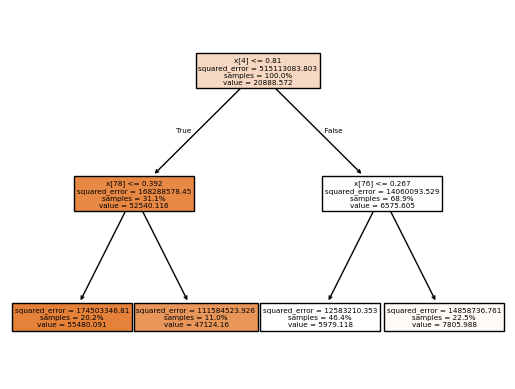

In [35]:
model = tree.ExtraTreeRegressor(max_depth=2,random_state=RANDOM_STATE)
model.fit(X_train, y_train)
tree.plot_tree(model, proportion=True, filled=True)
plt.show()

## Ансамбли

In [36]:
from sklearn import ensemble

Ансамбли - это мощный инструмент из арсенала ML специалиста и поэтому будет не простительным не уделить ему отдельное внимание.

### Теория об ансамблях

Ансамбли разделяются на 3 вида. Далее мы разберём каждый вид.

#### Бэггинг(паралельное обучени)

Идея бэггинга заключается в обучении множества моделей на разных подвыборках данных и усреднении их предсказаний. Пример такого алгоритма это *Random Forest* 

***!!!!!!! ХОЧУ КАРТИНКУ НО НЕ МОГУ НАЙТИ НИЧЕГО !!!!!!!***

Давайте сразу рассмотрим реализацию случайного леса на наших данных.

In [ ]:
EN_TREE_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=RANDOM_STATE)
EN_TREE_RandomForestRegressor.fit(X_train, y_train)
y_pred = EN_TREE_RandomForestRegressor.predict(X_test)

history_models.add_model(EN_TREE_RandomForestRegressor, "ensemble", EN_TREE_RandomForestRegressor.get_params(), "Случайный лес", y_true=y_test, y_pred=y_pred)

Так же мы можем использовать линейные модели. Давайте возьмём полиномиальную линейную модель и будем успользовать ```BaggingRegressor()```. Этот класс позволит нам использвать бэггинг с любой базовой моделью(деревья, линейные модели)

In [ ]:
EN_PLR_standart = ensemble.BaggingRegressor(
    estimator=linear_model.LinearRegression(),
    n_estimators=100,
    bootstrap=True
)
EN_PLR_standart.fit(X_poly_train, y_train)
y_pred = EN_PLR_standart.predict(X_test)

history_models.add_model(EN_PLR_standart, "ensemble", EN_PLR_standart.get_params(), "Бэггинг + полиномиальная линейная регрессия", y_true=y_test, y_pred=y_pred)

KeyboardInterrupt: 

#### Стекинг(комбинирование предсказаний)

#### Бустинг(последовательное улучшение)

# Результаты работы